
# Multiclass Receiver Operating Characteristic (ROC)

This example describes the use of the Receiver Operating Characteristic (ROC)
metric to evaluate the quality of multiclass classifiers.

ROC curves typically feature true positive rate (TPR) on the Y axis, and false
positive rate (FPR) on the X axis. This means that the top left corner of the
plot is the "ideal" point - a FPR of zero, and a TPR of one. This is not very
realistic, but it does mean that a larger area under the curve (AUC) is usually
better. The "steepness" of ROC curves is also important, since it is ideal to
maximize the TPR while minimizing the FPR.

ROC curves are typically used in binary classification, where the TPR and FPR
can be defined unambiguously. In the case of multiclass classification, a notion
of TPR or FPR is obtained only after binarizing the output. This can be done in
2 different ways:

- the One-vs-Rest scheme compares each class against all the others (assumed as
  one);
- the One-vs-One scheme compares every unique pairwise combination of classes.

In this example we explore both schemes and demo the concepts of micro and macro
averaging as different ways of summarizing the information of the multiclass ROC
curves.

<div class="alert alert-info"><h4>Note</h4><p>See `sphx_glr_auto_examples_model_selection_plot_roc_crossval.py` for
    an extension of the present example estimating the variance of the ROC
    curves and their respective AUC.</p></div>


## Load and prepare data

We import the `iris_dataset` which contains 3 classes, each one
corresponding to a type of iris plant. One class is linearly separable from
the other 2; the latter are **not** linearly separable from each other.

Here we binarize the output and add noisy features to make the problem harder.



In [2]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

We train a :class:`~sklearn.linear_model.LogisticRegression` model which can
naturally handle multiclass problems, thanks to the use of the multinomial
formulation.



In [3]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

# predict_proba(x_test)
# probabilidad de pertenencia de observacion a cada clase
y_score = classifier.fit(X_train, y_train).predict_proba(X_test) #
y_score


array([[0.38272852, 0.0510982 , 0.56617328],
       [0.06993073, 0.28143467, 0.6486346 ],
       [0.32803822, 0.09322052, 0.57874126],
       [0.65948627, 0.13963231, 0.20088142],
       [0.09538927, 0.19268834, 0.71192239],
       [0.64874871, 0.05224832, 0.29900297],
       [0.15355428, 0.29922447, 0.54722125],
       [0.66408011, 0.23863042, 0.09728946],
       [0.0180636 , 0.26683584, 0.71510056],
       [0.47170908, 0.15069637, 0.37759456],
       [0.70525134, 0.02195832, 0.27279034],
       [0.62685982, 0.09325078, 0.2798894 ],
       [0.03418275, 0.91183122, 0.05398604],
       [0.88837294, 0.07407626, 0.0375508 ],
       [0.0326032 , 0.13247171, 0.83492509],
       [0.78774127, 0.09897495, 0.11328378],
       [0.13202591, 0.23438849, 0.6335856 ],
       [0.5457628 , 0.21821535, 0.23602186],
       [0.61602466, 0.11388377, 0.27009157],
       [0.70742312, 0.15067818, 0.1418987 ],
       [0.07635884, 0.63861049, 0.28503067],
       [0.77388356, 0.08952173, 0.13659471],
       [0.

## One-vs-Rest multiclass ROC

The One-vs-the-Rest (OvR) multiclass strategy, also known as one-vs-all,
consists in computing a ROC curve per each of the `n_classes`. In each step, a
given class is regarded as the positive class and the remaining classes are
regarded as the negative class as a bulk.

<div class="alert alert-info"><h4>Note</h4><p>One should not confuse the OvR strategy used for the **evaluation**
    of multiclass classifiers with the OvR strategy used to **train** a
    multiclass classifier by fitting a set of binary classifiers (for instance
    via the :class:`~sklearn.multiclass.OneVsRestClassifier` meta-estimator).
    The OvR ROC evaluation can be used to scrutinize any kind of classification
    models irrespectively of how they were trained (see `multiclass`).</p></div>

In this section we use a :class:`~sklearn.preprocessing.LabelBinarizer` to
binarize the target by one-hot-encoding in a OvR fashion. This means that the
target of shape (`n_samples`,) is mapped to a target of shape (`n_samples`,
`n_classes`).



In [4]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

# We can as well easily check the encoding of a specific class
label_binarizer.transform(["virginica"]) # codificacion para clase especifica

array([[0, 0, 1]])

### ROC curve showing a specific class

In the following plot we show the resulting ROC curve when regarding the iris
flowers as either "virginica" (`class_id=2`) or "non-virginica" (the rest).



In [5]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id


2

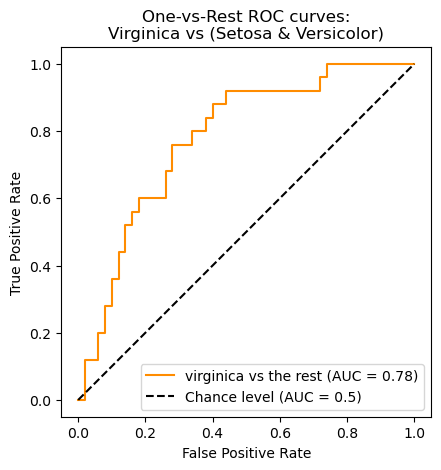

In [6]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

### ROC curve using micro-averaged OvR

Micro-averaging aggregates the contributions from all the classes (using
:func:`np.ravel`) to compute the average metrics as follows:

$TPR=\frac{\sum_{c}TP_c}{\sum_{c}(TP_c + FN_c)}$ ;

$FPR=\frac{\sum_{c}FP_c}{\sum_{c}(FP_c + TN_c)}$ .

We can briefly demo the effect of :func:`np.ravel`:



In [7]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.38272852 0.0510982  0.56617328]
 [0.06993073 0.28143467 0.6486346 ]]

y_score.ravel():
[0.38272852 0.0510982  0.56617328 0.06993073 0.28143467 0.6486346 ]


In a multi-class classification setup with highly imbalanced classes,
micro-averaging is preferable over macro-averaging. In such cases, one can
alternatively use a weighted macro-averaging, not demoed here.



In [2]:
# mapeo de columnas DSM
column_to_class_dsm = {
    'dsm_bipolarI': 1,
    'dsm_bipolarII': 2,
    'dsm_dys': 3,
    'dsm_gad': 4,
    'dsm_hyp': 5,
    'dsm_man': 6,
    'dsm_mddh': 7,
    'dsm_mde': 8,
    'dsm_mnd': 9,
    'dsm_pds': 10,
    'dsm_so': 11
}


column_to_class_dsm 

{'dsm_bipolarI': 1,
 'dsm_bipolarII': 2,
 'dsm_dys': 3,
 'dsm_gad': 4,
 'dsm_hyp': 5,
 'dsm_man': 6,
 'dsm_mddh': 7,
 'dsm_mde': 8,
 'dsm_mnd': 9,
 'dsm_pds': 10,
 'dsm_so': 11}

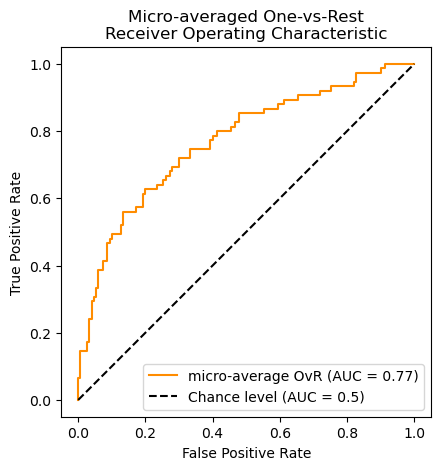

In [8]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In the case where the main interest is not the plot but the ROC-AUC score
itself, we can reproduce the value shown in the plot using
:class:`~sklearn.metrics.roc_auc_score`.



In [9]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


This is equivalent to computing the ROC curve with
:class:`~sklearn.metrics.roc_curve` and then the area under the curve with
:class:`~sklearn.metrics.auc` for the raveled true and predicted classes.



In [10]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


<div class="alert alert-info"><h4>Note</h4><p>By default, the computation of the ROC curve adds a single point at
    the maximal false positive rate by using linear interpolation and the
    McClish correction [:doi:`Analyzing a portion of the ROC curve Med Decis
    Making. 1989 Jul-Sep; 9(3):190-5.<10.1177/0272989x8900900307>`].</p></div>

### ROC curve using the OvR macro-average

Obtaining the macro-average requires computing the metric independently for
each class and then taking the average over them, hence treating all classes
equally a priori. We first aggregate the true/false positive rates per class:



In [11]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)


# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.77


This computation is equivalent to simply calling



In [12]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.77


### Plot all OvR ROC curves together



In [13]:
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [14]:
n_classes

3

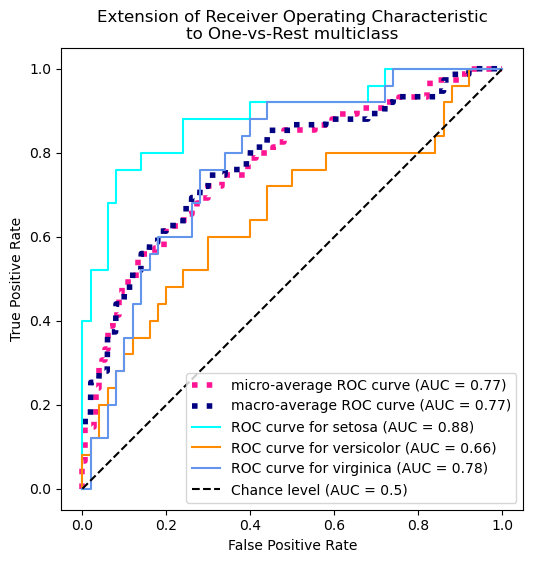

In [15]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

## One-vs-One multiclass ROC

The One-vs-One (OvO) multiclass strategy consists in fitting one classifier
per class pair. Since it requires to train `n_classes` * (`n_classes` - 1) / 2
classifiers, this method is usually slower than One-vs-Rest due to its
O(`n_classes` ^2) complexity.

In this section, we demonstrate the macro-averaged AUC using the OvO scheme
for the 3 possible combinations in the `iris_dataset`: "setosa" vs
"versicolor", "versicolor" vs "virginica" and  "virginica" vs "setosa". Notice
that micro-averaging is not defined for the OvO scheme.

### ROC curve using the OvO macro-average

In the OvO scheme, the first step is to identify all possible unique
combinations of pairs. The computation of scores is done by treating one of
the elements in a given pair as the positive class and the other element as
the negative class, then re-computing the score by inversing the roles and
taking the mean of both scores.



In [16]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[('setosa', 'versicolor'), ('setosa', 'virginica'), ('versicolor', 'virginica')]


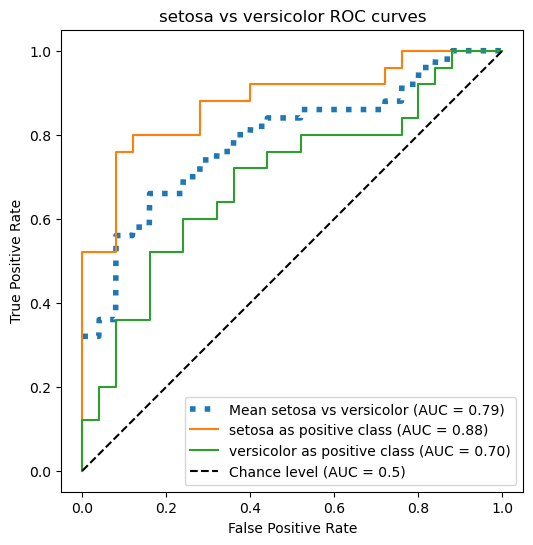

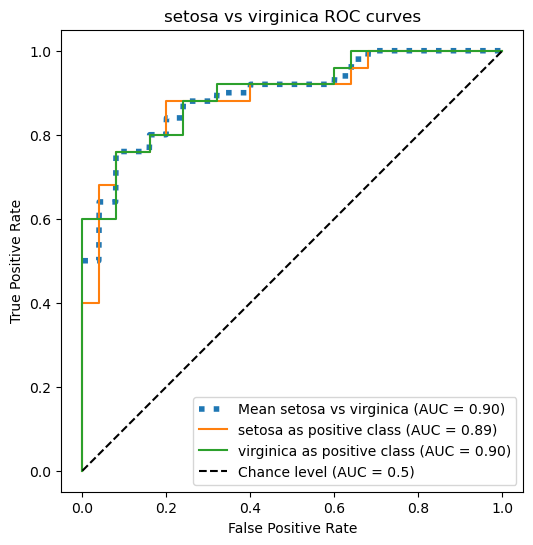

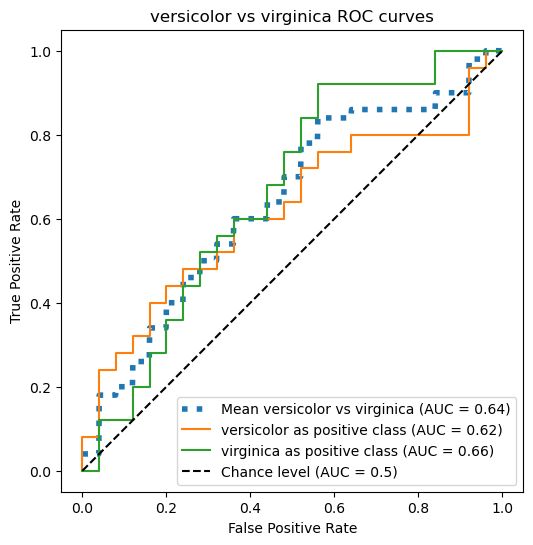

Macro-averaged One-vs-One ROC AUC score:
0.77


: 

In [20]:
pair_list = list(combinations(np.unique(y), 2))
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):
    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_b} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

One can also assert that the macro-average we computed "by hand" is equivalent
to the implemented `average="macro"` option of the
:class:`~sklearn.metrics.roc_auc_score` function.



In [18]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Macro-averaged One-vs-One ROC AUC score:
0.77


### Plot all OvO ROC curves together



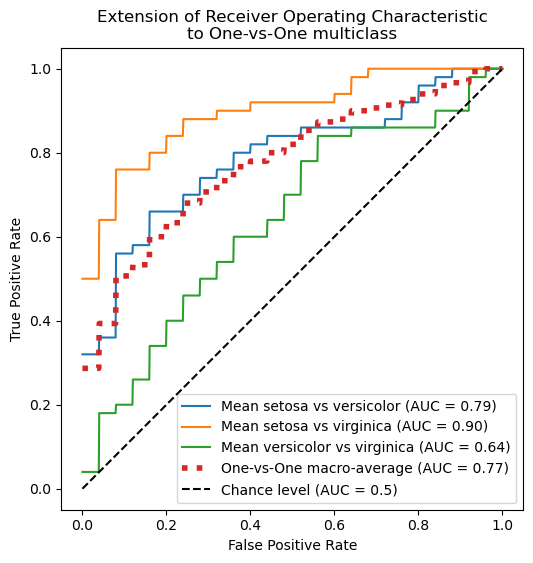

In [19]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

We confirm that the classes "versicolor" and "virginica" are not well
identified by a linear classifier. Notice that the "virginica"-vs-the-rest
ROC-AUC score (0.77) is between the OvO ROC-AUC scores for "versicolor" vs
"virginica" (0.64) and "setosa" vs "virginica" (0.90). Indeed, the OvO
strategy gives additional information on the confusion between a pair of
classes, at the expense of computational cost when the number of classes
is large.

The OvO strategy is recommended if the user is mainly interested in correctly
identifying a particular class or subset of classes, whereas evaluating the
global performance of a classifier can still be summarized via a given
averaging strategy.

Micro-averaged OvR ROC is dominated by the more frequent class, since the
counts are pooled. The macro-averaged alternative better reflects the
statistics of the less frequent classes, and then is more appropriate when
performance on all the classes is deemed equally important.

